# Projeto

## Modeling

In [1]:
import pandas as pd
import numpy as np
import dslabs_functions as dslabs
from matplotlib.pyplot import figure, show, subplots, plot, legend, savefig
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from torch import no_grad, tensor
from torch.nn import LSTM, Linear, Module, MSELoss
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from copy import deepcopy

In [2]:
### Plotting UNIVARIATE Time Series
file_tag = "traffic"
target = "Total"
index="Timestamp"
### ordenar dados no csv ou nao e preciso??? last timestamp esta mal pq dados no csv nao estao ordenados por data
original_data: pd.DataFrame = pd.read_csv(
    "forecast_traffic_single.csv",
    index_col="Timestamp",
    sep=",",
    decimal=".",
    parse_dates=True,
    infer_datetime_format=True,
)

In [3]:
### Sort 'TimeStamp' Ascending
original_data.sort_index(inplace=True)

#original_data.index = pd.to_datetime(original_data.index)
#original_data.to_csv("sorted_forecast_traffic.csv")
data = original_data.copy()

series_og: pd.Series = original_data[target]

# Output the inferred frequency
inferred_freq = pd.infer_freq(series_og.index)
print("Inferred frequency of the DateTimeIndex: ", inferred_freq)

print("Nr. Records = ", series_og.shape[0])
print("First timestamp", series_og.index[0])
print("Last timestamp", series_og.index[-1])

## Using atomic granularity

### Smoothing
WIN_SIZE = 32
ss_smooth: pd.Series = series_og.rolling(WIN_SIZE).mean()
ss_smooth.bfill(inplace=True)

### Differentiation
ss_diff: pd.Series = ss_smooth.diff()
ss_diff.bfill(inplace=True)

### Scaling useful for LSTMs
data[target] = ss_diff

## Use this
data_scaled: pd.DataFrame = dslabs.scale_all_dataframe(data)
series_data: pd.Series = data_scaled[target]

Inferred frequency of the DateTimeIndex:  15T
Nr. Records =  2976
First timestamp 2023-10-01 00:00:00
Last timestamp 2023-10-31 23:45:00


<Axes: title={'center': 'traffic Total after scaling'}, xlabel='Timestamp', ylabel='Total'>

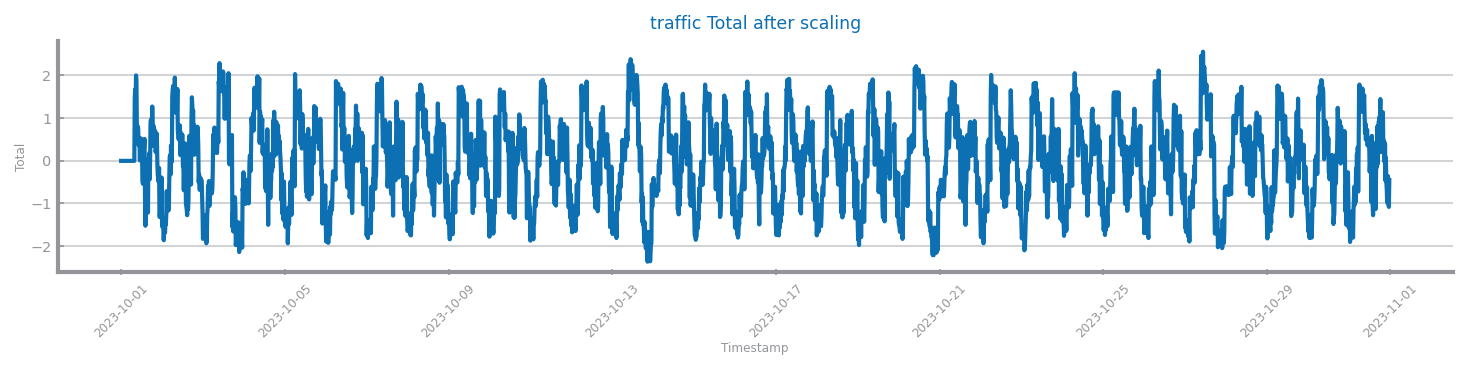

In [4]:
figure(figsize=(3 * dslabs.HEIGHT, dslabs.HEIGHT / 2))
dslabs.plot_line_chart(
    series_data.index.to_list(),
    series_data.to_list(),
    xlabel=series_data.index.name,
    ylabel=target,
    title=f"{file_tag} {target} after scaling",
)

## Simple Average Model

*always predicting the outcome to be the data mean value*

In [5]:
from sklearn.base import RegressorMixin

class SimpleAvgRegressor(RegressorMixin):
    def __init__(self):
        super().__init__()
        self.mean: float = 0.0
        return

    def fit(self, X: pd.Series):
        self.mean = X.mean()
        return

    def predict(self, X: pd.Series) -> pd.Series:
        prd: list = len(X) * [self.mean]
        prd_series: pd.Series = pd.Series(prd)
        prd_series.index = X.index
        return prd_series

{'RMSE': [1.0066607827967402, 0.9380461367183992], 'MAE': [0.8347581412913471, 0.7738124206419047]} {'MAPE': [1.0061052104578316, 1.002332478797869], 'R2': [0.0, -0.0005056471364091042]}


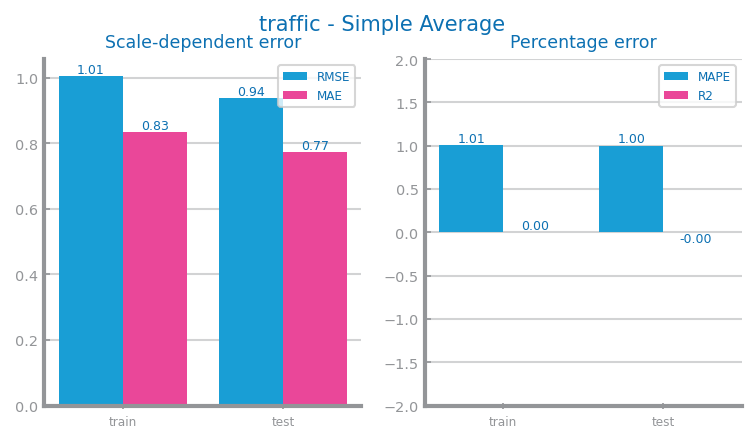

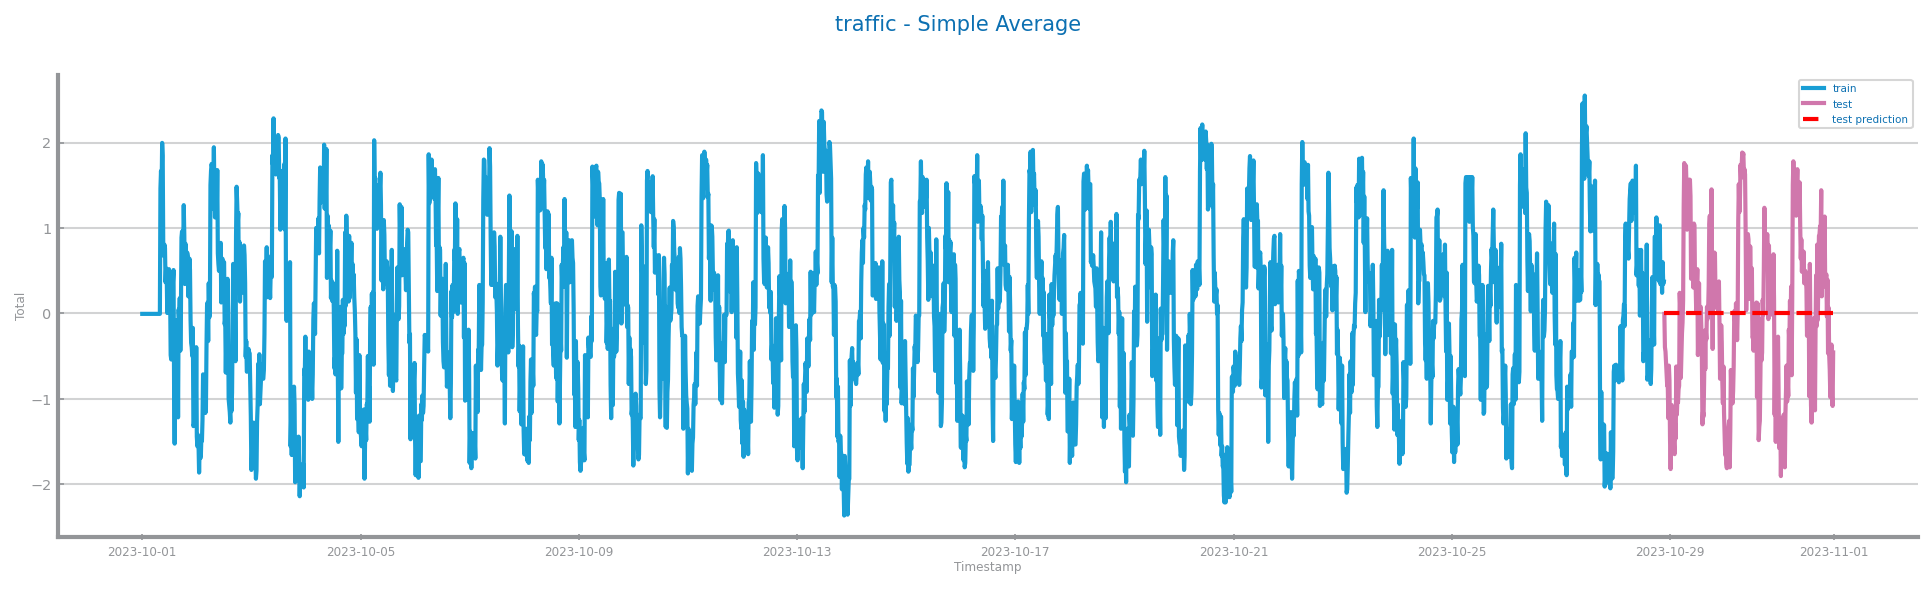

In [6]:
train_sam, test_sam = dslabs.series_train_test_split(data_scaled, trn_pct=0.90)

trnX_sam = np.arange(len(train_sam)).reshape(-1, 1)
trnY_sam = train_sam.to_numpy()

tstX = np.arange(len(train_sam), len(data_scaled)).reshape(-1, 1)
tstY = test_sam.to_numpy()

fr_mod = SimpleAvgRegressor()
fr_mod.fit(train_sam)
prd_trn_sam: pd.Series = fr_mod.predict(train_sam)
prd_tst_sam: pd.Series = fr_mod.predict(test_sam)

dslabs.plot_forecasting_eval(train_sam, test_sam, prd_trn_sam, prd_tst_sam, title=f"{file_tag} - Simple Average")
savefig("../forecasting_services/modeling_images/results_Simple_Average", bbox_inches='tight')

dslabs.plot_forecasting_series(
    train_sam,
    test_sam,
    prd_tst_sam,
    title=f"{file_tag} - Simple Average",
    xlabel="Timestamp",
    ylabel=target,
)
savefig("../forecasting_services/modeling_images/plot_Simple_Average", bbox_inches='tight')
show()

## Persistence Model

In [7]:
class PersistenceOptimistRegressor(RegressorMixin):
    def __init__(self):
        super().__init__()
        self.last: float = 0.0
        return

    def fit(self, X: pd.Series):
        self.last = X.iloc[-1]
        # print(self.last)
        return

    def predict(self, X: pd.Series):
        prd: list = X.shift().values.ravel()
        prd[0] = self.last
        prd_series: pd.Series = pd.Series(prd)
        prd_series.index = X.index
        return prd_series

{'RMSE': [0.4988106765464957, 0.4804233452077121], 'MAE': [0.36875277527524625, 0.3765522779316993]} {'MAPE': [1.9006089334994845, 2.103797560217777], 'R2': [0.7544696508212178, 0.7375664521458491]}


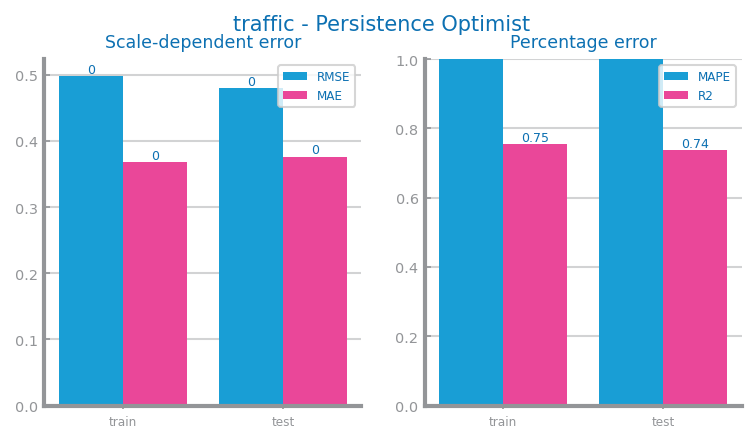

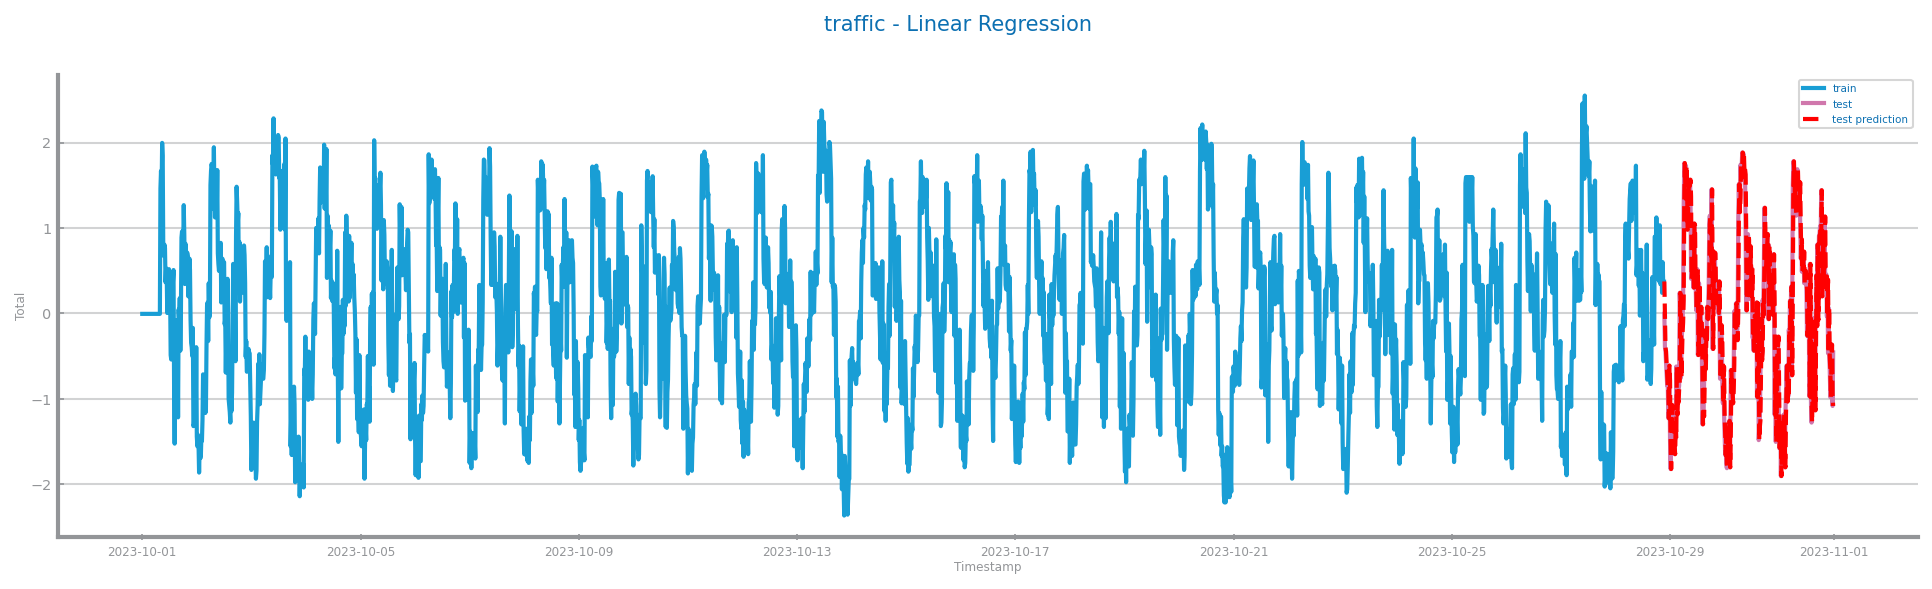

In [8]:
# Figure 88 Forecasting plots obtained with Persistence model (long term) over time series 2
# PersistenceOptimistRegressor REALISTA MUDAR ISTO
train_pm, test_pm = dslabs.series_train_test_split(data_scaled, trn_pct=0.90)

fr_mod = PersistenceOptimistRegressor()
fr_mod.fit(train_pm)
prd_trn_pm: pd.Series = fr_mod.predict(train_pm)
prd_tst_pm: pd.Series = fr_mod.predict(test_pm)

dslabs.plot_forecasting_eval(train_pm, test_pm, prd_trn_pm, prd_tst_pm, title=f"{file_tag} - Persistence Optimist")

dslabs.plot_forecasting_series(
    train_pm,
    test_pm,
    prd_tst_pm,
    title=f"{file_tag} - Linear Regression",
    xlabel="Timestamp",
    ylabel=target,
)
show()

In [9]:
class PersistenceRealistRegressor(RegressorMixin):
    def __init__(self):
        super().__init__()
        self.last = 0
        self.estimations = [0]
        self.obs_len = 0

    def fit(self, X: pd.Series):
        for i in range(1, len(X)):
            self.estimations.append(X.iloc[i - 1])
        self.obs_len = len(self.estimations)
        self.last = X.iloc[len(X) - 1]
        prd_series: pd.Series = pd.Series(self.estimations)
        prd_series.index = X.index
        return prd_series

    def predict(self, X: pd.Series):
        prd: list = len(X) * [self.last]
        prd_series: pd.Series = pd.Series(prd)
        prd_series.index = X.index
        return prd_series

{'RMSE': [1.0735261371714124, 1.0172279354270317], 'MAE': [0.8724840511441386, 0.8360293604650498]} {'MAPE': [3.0768822383473275, 2.6439096482574267], 'R2': [-0.13725785644554, -0.1765427247779452]}


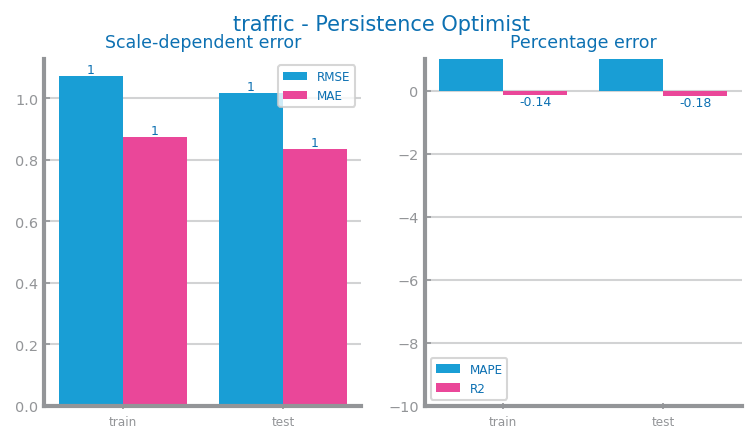

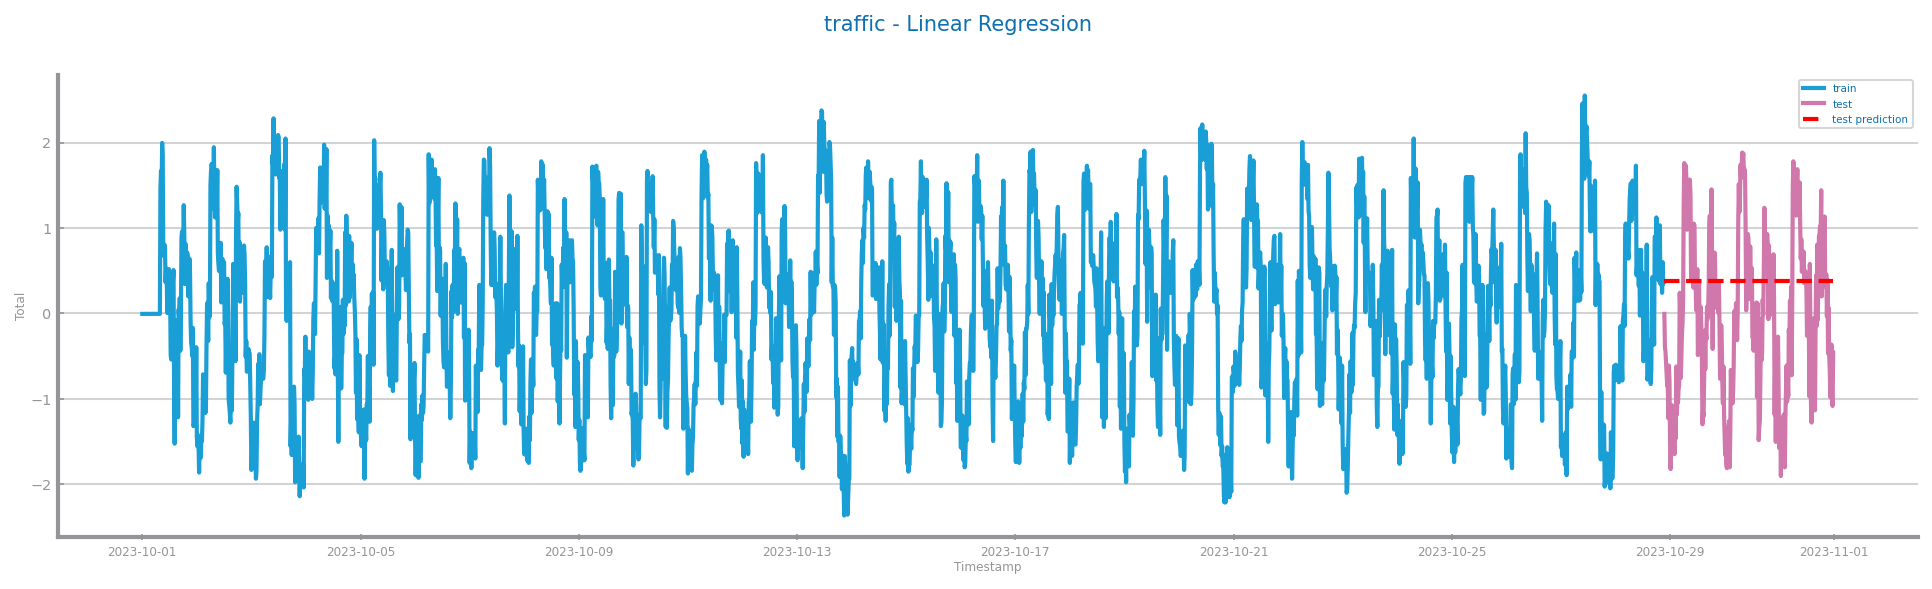

In [10]:
# Figure 89 Forecasting plots obtained with Persistence model (one-set-behind) over time series 2
# PersistenceRealistRegressor
train_pm, test_pm = dslabs.series_train_test_split(data_scaled, trn_pct=0.90)

fr_mod = PersistenceRealistRegressor()
fr_mod.fit(train_pm)
prd_trn_pm: pd.Series = fr_mod.predict(train_pm)
prd_tst_pm: pd.Series = fr_mod.predict(test_pm)

dslabs.plot_forecasting_eval(train_pm, test_pm, prd_trn_pm, prd_tst_pm, title=f"{file_tag} - Persistence Optimist")

dslabs.plot_forecasting_series(
    train_pm,
    test_pm,
    prd_tst_pm,
    title=f"{file_tag} - Linear Regression",
    xlabel="Timestamp",
    ylabel=target,
)
show()

In [11]:
# Figure 86 Forecasting results obtained with Persistence model in both situation over time series 2
# PersistenceOptimistRegressor && PersistenceRealistRegressor

# Assuming data_scaled is your prepared DataFrame and the series are already scaled
train_pm, test_pm = dslabs.series_train_test_split(data_scaled, trn_pct=0.90)

# Persistence Optimist Regressor
optimist_model = PersistenceOptimistRegressor()
optimist_model.fit(train_pm)
optimist_pred_train = optimist_model.predict(train_pm)
optimist_pred_test = optimist_model.predict(test_pm)

# Persistence Realist Regressor
realist_model = PersistenceRealistRegressor()
realist_model.fit(train_pm)
realist_pred_train = realist_model.predict(train_pm)
realist_pred_test = realist_model.predict(test_pm)

# Plotting
# dslabs.plot_forecasting_eval(train_pm, test_pm, prd_trn_pm, prd_tst_pm, title=f"{file_tag} - Persistence Optimist")

# dslabs.plot_forecasting_series(
#     train_pm,
#     test_pm,
#     prd_tst_pm,
#     title=f"{file_tag} - Linear Regression",
#     xlabel="Timestamp",
#     ylabel=target,
# )
# show()


## Rolling Mean Model

In [12]:
class RollingMeanRegressor(RegressorMixin):
    def __init__(self, win: int = 3):
        super().__init__()
        self.win_size = win
        self.memory: list = []

    def fit(self, X: pd.Series):
        self.memory = X.iloc[-self.win_size :]
        # print(self.memory)
        return

    def predict(self, X: pd.Series):
        estimations = self.memory.tolist()
        for i in range(len(X)):
            new_value = np.mean(estimations[len(estimations) - self.win_size - i :])
            estimations.append(new_value)
        prd_series: pd.Series = pd.Series(estimations[self.win_size :])
        prd_series.index = X.index
        return prd_series
    
def rolling_mean_study(train: pd.Series, test: pd.Series, measure: str = "R2"):
    # win_size = (3, 5, 10, 15, 20, 25, 30, 40, 50)
    win_size = (12, 24, 48, 96, 192, 384, 768)
    flag = measure == "R2" or measure == "MAPE"
    best_model = None
    best_params: dict = {"name": "Rolling Mean", "metric": measure, "params": ()}
    best_performance: float = -100000

    yvalues = []
    for w in win_size:
        pred = RollingMeanRegressor(win=w)
        pred.fit(train)
        prd_tst = pred.predict(test)

        eval: float = dslabs.FORECAST_MEASURES[measure](test, prd_tst)
        # print(w, eval)
        if eval > best_performance and abs(eval - best_performance) > dslabs.DELTA_IMPROVE:
            best_performance: float = eval
            best_params["params"] = (w,)
            best_model = pred
        yvalues.append(eval)

    print(f"Rolling Mean best with win={best_params['params'][0]:.0f} -> {measure}={best_performance}")
    dslabs.plot_line_chart(
        win_size, yvalues, title=f"Rolling Mean ({measure})", xlabel="window size", ylabel=measure, percentage=flag
    )

    return best_model, best_params

Rolling Mean best with win=192 -> R2=-6.66002129807719e-05


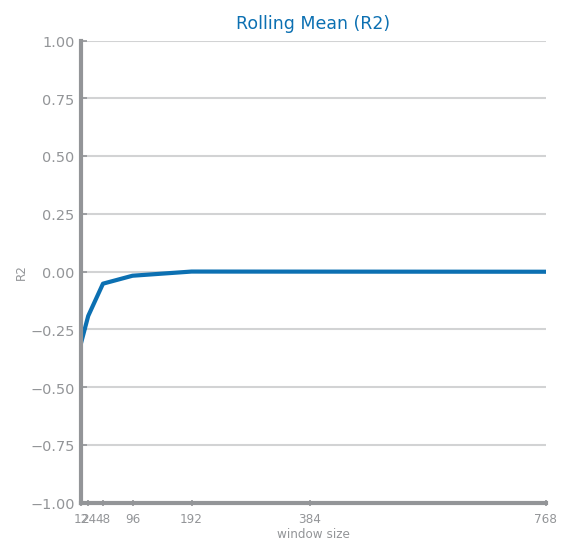

In [13]:
train, test = dslabs.series_train_test_split(data_scaled, trn_pct=0.90)

fig = figure(figsize=(dslabs.HEIGHT, dslabs.HEIGHT))
best_model, best_params = rolling_mean_study(train, test)

{'RMSE': [1.0067504282566173, 0.9378402950704442], 'MAE': [0.8353641335432678, 0.7737238825368685]} {'MAPE': [1.0173738957941492, 1.0079622705198303], 'R2': [-0.00017811253398636318, -6.66002129807719e-05]}


array([<Axes: title={'center': 'Scale-dependent error'}>,
       <Axes: title={'center': 'Percentage error'}>], dtype=object)

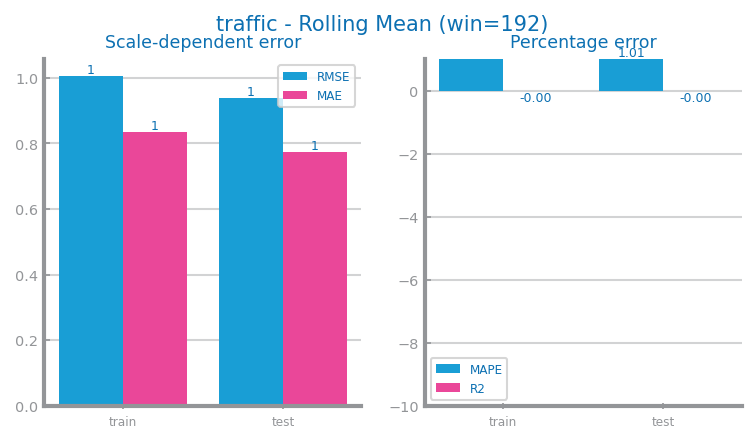

In [14]:
params = best_params["params"]
prd_trn: pd.Series = best_model.predict(train)
prd_tst: pd.Series = best_model.predict(test)

dslabs.plot_forecasting_eval(train, test, prd_trn, prd_tst, title=f"{file_tag} - Rolling Mean (win={params[0]})")

<Axes: xlabel='TimeStamp', ylabel='Total'>

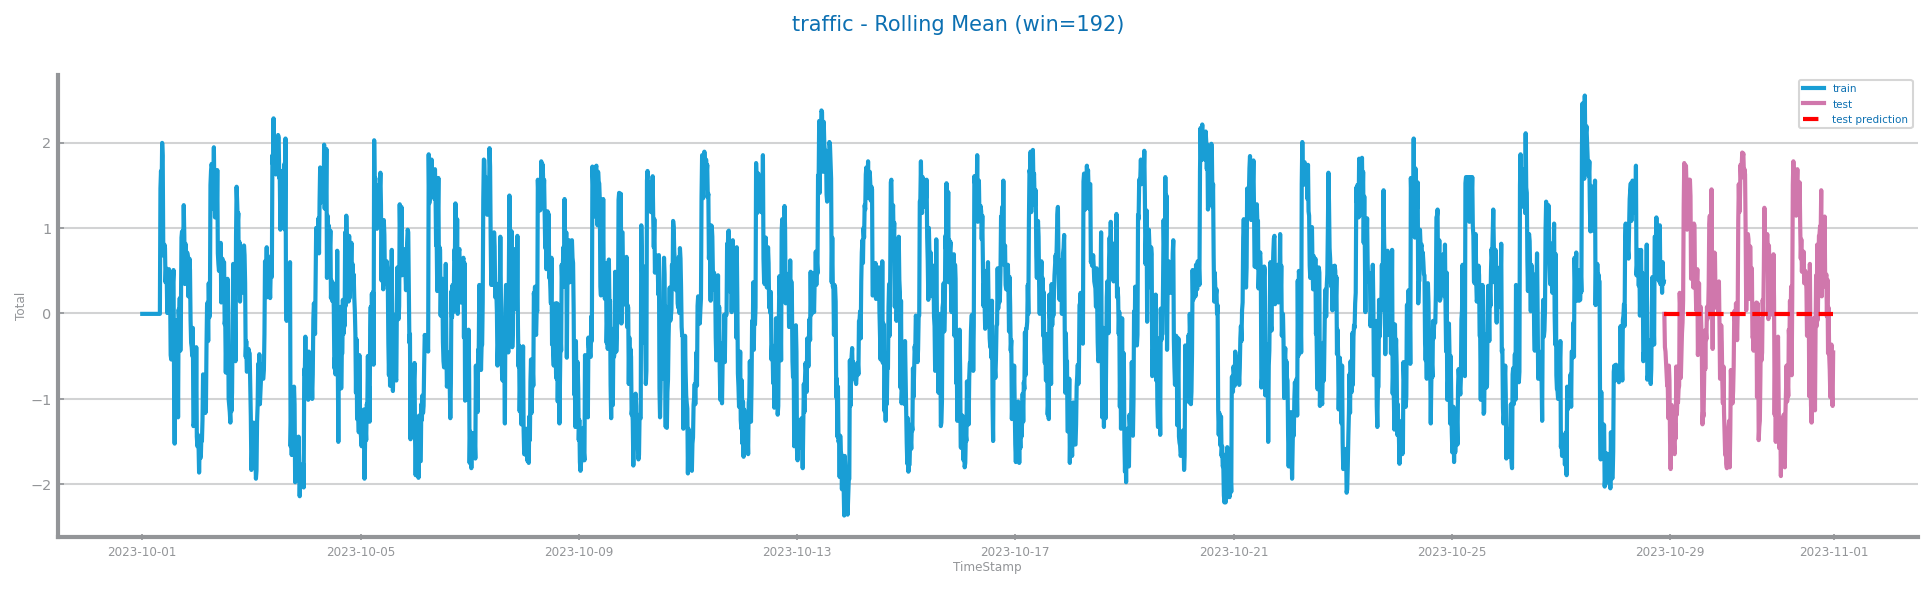

In [15]:
dslabs.plot_forecasting_series(
    train,
    test,
    prd_tst,
    title=f"{file_tag} - Rolling Mean (win={params[0]})",
    xlabel="TimeStamp",
    ylabel=target,
)

## ARIMA Model

In [19]:
train, test = dslabs.series_train_test_split(data_scaled, trn_pct=0.90)

predictor = ARIMA(train, order=(3, 1, 2))
model = predictor.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                 2678
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -1787.231
Date:                Wed, 20 Dec 2023   AIC                           3586.461
Time:                        19:11:17   BIC                           3621.816
Sample:                    10-01-2023   HQIC                          3599.252
                         - 10-28-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6482      0.708     -0.916      0.360      -2.036       0.739
ar.L2          0.0892      0.199      0.449      0.653      -0.300       0.479
ar.L3          0.0274      0.065      0.424      0.6

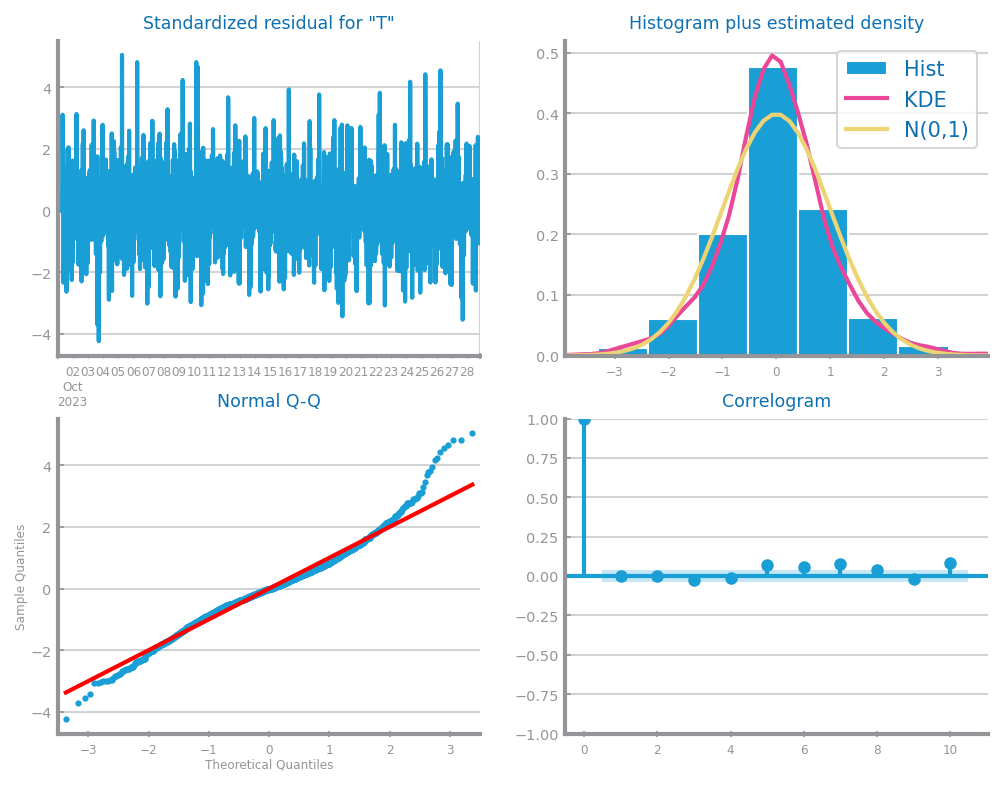

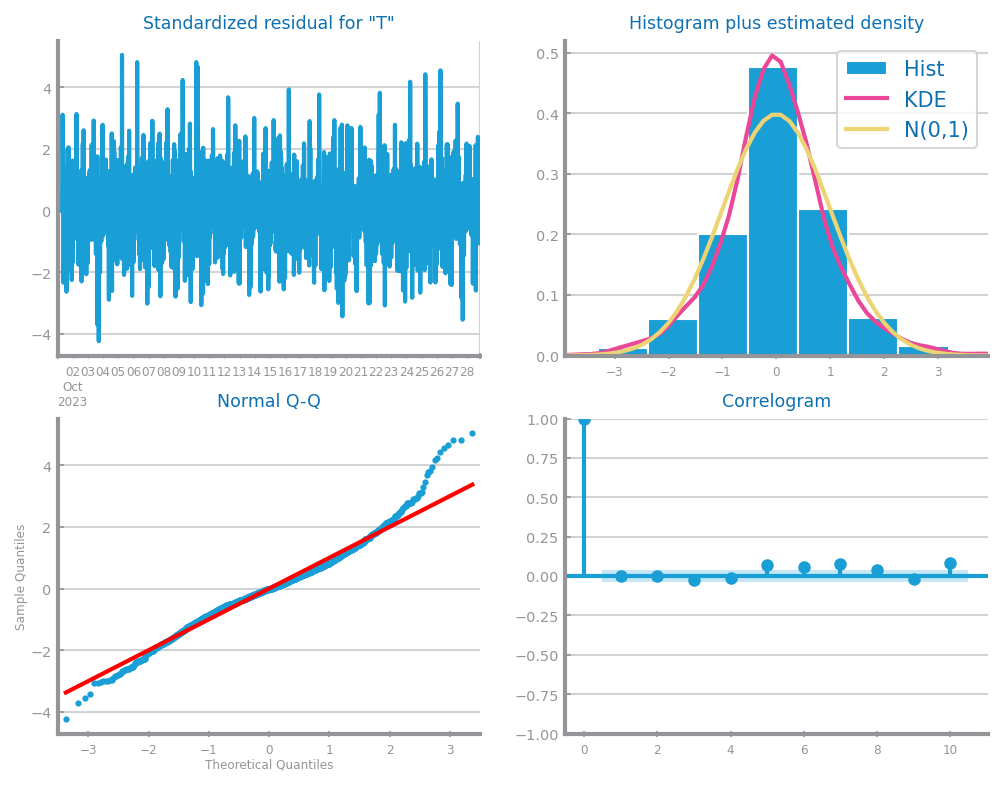

In [20]:
model.plot_diagnostics(figsize=(2 * dslabs.HEIGHT, 1.5 * dslabs.HEIGHT))

In [22]:
def arima_study(train: pd.Series, test: pd.Series, measure: str = "R2"):
    d_values = (0, 1, 2)
    p_params = (1, 2, 3, 5, 7, 10)
    q_params = (1, 3, 5, 7)

    flag = measure == "R2" or measure == "MAPE"
    best_model = None
    best_params: dict = {"name": "ARIMA", "metric": measure, "params": ()}
    best_performance: float = -100000

    fig, axs = subplots(1, len(d_values), figsize=(len(d_values) * dslabs.HEIGHT, dslabs.HEIGHT))
    for i in range(len(d_values)):
        d: int = d_values[i]
        values = {}
        for q in q_params:
            yvalues = []
            for p in p_params:
                arima = ARIMA(train, order=(p, d, q))
                model = arima.fit()
                prd_tst = model.forecast(steps=len(test), signal_only=False)
                eval: float = dslabs.FORECAST_MEASURES[measure](test, prd_tst)
                # print(f"ARIMA ({p}, {d}, {q})", eval)
                if eval > best_performance and abs(eval - best_performance) > dslabs.DELTA_IMPROVE:
                    best_performance: float = eval
                    best_params["params"] = (p, d, q)
                    best_model = model
                yvalues.append(eval)
            values[q] = yvalues
        dslabs.plot_multiline_chart(
            p_params, values, ax=axs[i], title=f"ARIMA d={d} ({measure})", xlabel="p", ylabel=measure, percentage=flag
        )
    print(
        f"ARIMA best results achieved with (p,d,q)=({best_params['params'][0]:.0f}, {best_params['params'][1]:.0f}, {best_params['params'][2]:.0f}) ==> measure={best_performance:.2f}"
    )

    return best_model, best_params

ARIMA best results achieved with (p,d,q)=(3, 0, 7) ==> measure=0.28


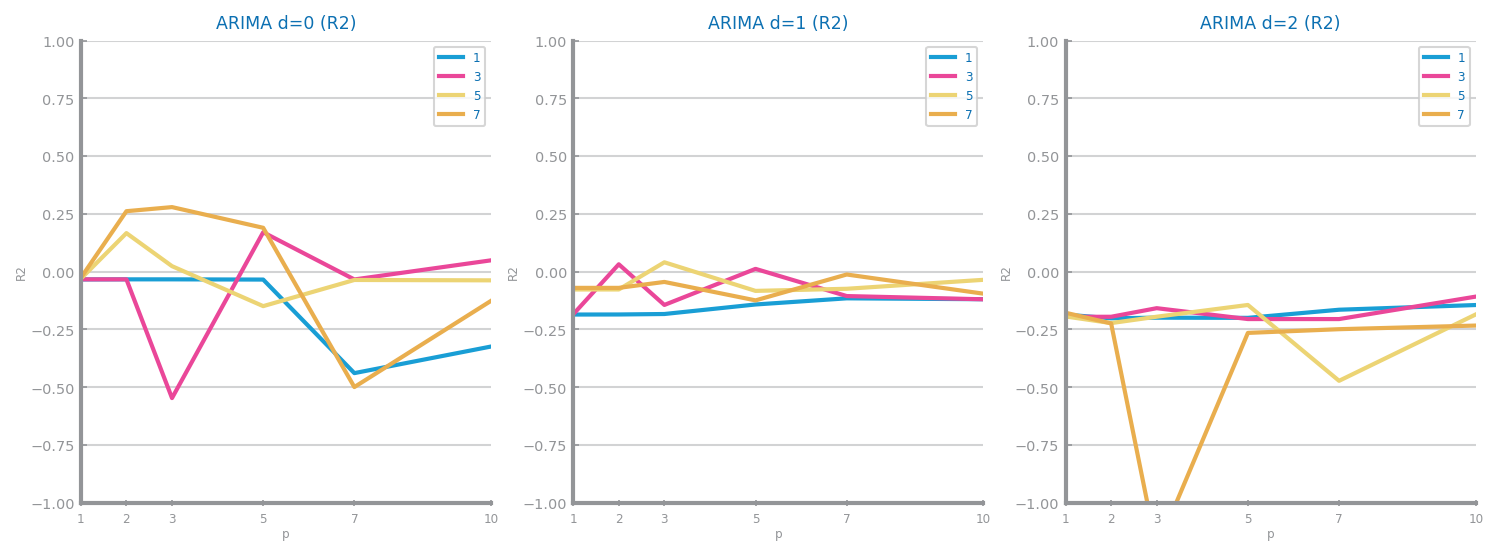

In [23]:
measure: str = "R2" ## R2 ou outra measure
best_model, best_params = arima_study(train, test, measure=measure)

{'RMSE': [0.4410126069705803, 0.7963388972517093], 'MAE': [0.33594334872856607, 0.6597253903415854]} {'MAPE': [1.590426570669934, 1.4345917915639599], 'R2': [0.808073161492725, 0.2789473044964915]}


array([<Axes: title={'center': 'Scale-dependent error'}>,
       <Axes: title={'center': 'Percentage error'}>], dtype=object)

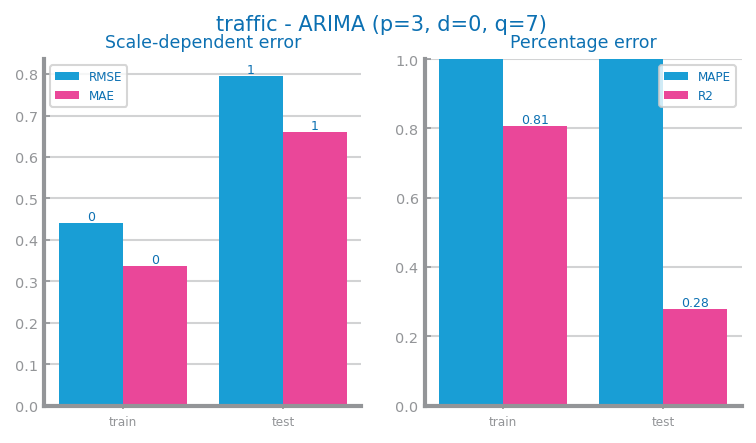

In [24]:
params = best_params["params"]
prd_trn = best_model.predict(start=0, end=len(train) - 1)
prd_tst = best_model.forecast(steps=len(test))

### mudar range desta funcao
dslabs.plot_forecasting_eval(
    train, test, prd_trn, prd_tst, title=f"{file_tag} - ARIMA (p={params[0]}, d={params[1]}, q={params[2]})"
)

<Axes: xlabel='TimeStamp', ylabel='Total'>

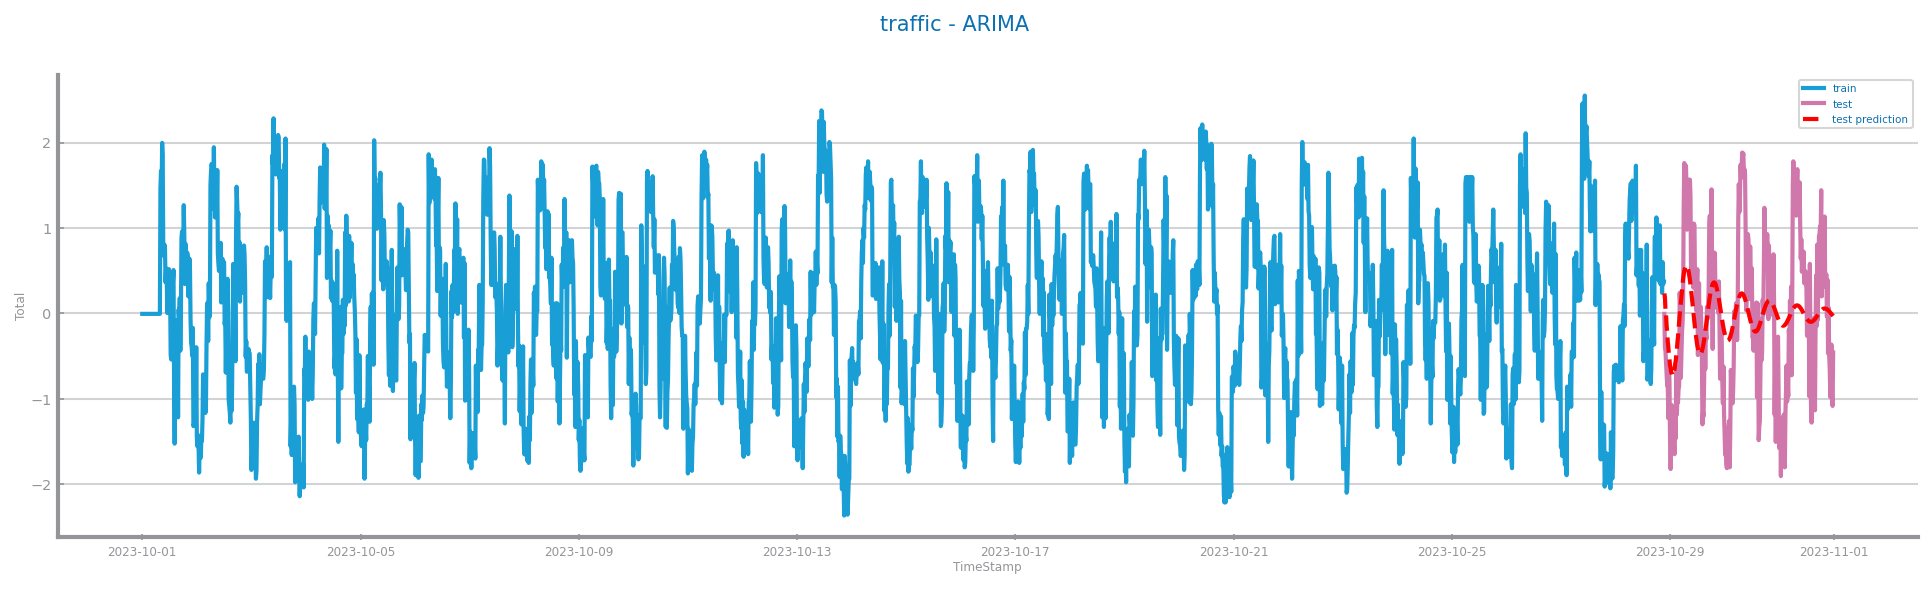

In [25]:
dslabs.plot_forecasting_series(
    train,
    test,
    prd_tst,
    title=f"{file_tag} - ARIMA ",
    xlabel="TimeStamp",
    ylabel=target,
)

## LSTMs

In [5]:
import torch

def prepare_dataset_for_lstm(series, seq_length: int = 4):
    setX: list = []
    setY: list = []
    for i in range(len(series) - seq_length):
        past = series[i : i + seq_length]
        future = series[i + 1 : i + seq_length + 1]
        setX.append(past)
        setY.append(future)
    return tensor(setX), tensor(setY)
    #return tensor(setX, dtype=torch.float32), tensor(setY, dtype=torch.float32)


class DS_LSTM(Module):
    def __init__(self, train, input_size: int = 1, hidden_size: int = 50, num_layers: int = 1, length: int = 4):
        super().__init__()
        self.lstm = LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.linear = Linear(hidden_size, 1)
        self.optimizer = Adam(self.parameters())
        self.loss_fn = MSELoss()

        trnX, trnY = prepare_dataset_for_lstm(train, seq_length=length)
        self.loader = DataLoader(TensorDataset(trnX, trnY), shuffle=True, batch_size=len(train) // 10)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

    def fit(self):
        self.train()
        for batchX, batchY in self.loader:
            y_pred = self(batchX)
            loss = self.loss_fn(y_pred, batchY)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        return loss

    def predict(self, X):
        with no_grad():
            y_pred = self(X)
        return y_pred[:, -1, :]

In [8]:
measure: str = "R2"

series_data = data_scaled[[target]].values.astype("float32")
train_size = int(len(series_data) * 0.90)
train, test = series_data[:train_size], series_data[train_size:]

In [9]:
model = DS_LSTM(train, input_size=1, hidden_size=50, num_layers=1)
loss = model.fit()
print(loss)

tensor(0.7108, grad_fn=<MseLossBackward0>)


In [10]:
def lstm_study(train, test, nr_episodes: int = 1000, measure: str = "R2"):
    sequence_size = [2, 4, 8]
    nr_hidden_units = [25, 50, 100]

    step: int = nr_episodes // 10
    episodes = [1] + list(range(0, nr_episodes + 1, step))[1:]
    flag = measure == "R2" or measure == "MAPE"
    best_model = None
    best_params: dict = {"name": "LSTM", "metric": measure, "params": ()}
    best_performance: float = -100000

    _, axs = subplots(1, len(sequence_size), figsize=(len(sequence_size) * dslabs.HEIGHT, dslabs.HEIGHT))

    for i in range(len(sequence_size)):
        length = sequence_size[i]
        tstX, tstY = prepare_dataset_for_lstm(test, seq_length=length)

        values = {}
        for hidden in nr_hidden_units:
            yvalues = []
            model = DS_LSTM(train, hidden_size=hidden)
            for n in range(0, nr_episodes + 1):
                model.fit()
                if n % step == 0:
                    prd_tst = model.predict(tstX)
                    eval: float = dslabs.FORECAST_MEASURES[measure](test[length:], prd_tst)
                    print(f"seq length={length} hidden_units={hidden} nr_episodes={n}", eval)
                    if eval > best_performance and abs(eval - best_performance) > dslabs.DELTA_IMPROVE:
                        best_performance: float = eval
                        best_params["params"] = (length, hidden, n)
                        best_model = deepcopy(model)
                    yvalues.append(eval)
            values[hidden] = yvalues
        dslabs.plot_multiline_chart(
            episodes,
            values,
            ax=axs[i],
            title=f"LSTM seq length={length} ({measure})",
            xlabel="nr episodes",
            ylabel=measure,
            percentage=flag,
        )
    print(
        f"LSTM best results achieved with length={best_params["params"][0]} hidden_units={best_params["params"][1]} and nr_episodes={best_params["params"][2]}) ==> measure={best_performance:.2f}"
    )
    return best_model, best_params

seq length=2 hidden_units=25 nr_episodes=0 0.03550056259593393
seq length=2 hidden_units=25 nr_episodes=300 0.7634880325096214
seq length=2 hidden_units=25 nr_episodes=600 0.7606681245869329
seq length=2 hidden_units=25 nr_episodes=900 0.7579184601510005
seq length=2 hidden_units=25 nr_episodes=1200 0.756684878271831
seq length=2 hidden_units=25 nr_episodes=1500 0.7556356542593741
seq length=2 hidden_units=25 nr_episodes=1800 0.7546128222560804
seq length=2 hidden_units=25 nr_episodes=2100 0.7527631826291175
seq length=2 hidden_units=25 nr_episodes=2400 0.7532072957921557
seq length=2 hidden_units=25 nr_episodes=2700 0.7503238953814126
seq length=2 hidden_units=25 nr_episodes=3000 0.7512844325740325
seq length=2 hidden_units=50 nr_episodes=0 0.06742014620168268
seq length=2 hidden_units=50 nr_episodes=300 0.7616548560791501
seq length=2 hidden_units=50 nr_episodes=600 0.7580412249005349
seq length=2 hidden_units=50 nr_episodes=900 0.7564697717286185
seq length=2 hidden_units=50 nr_epis

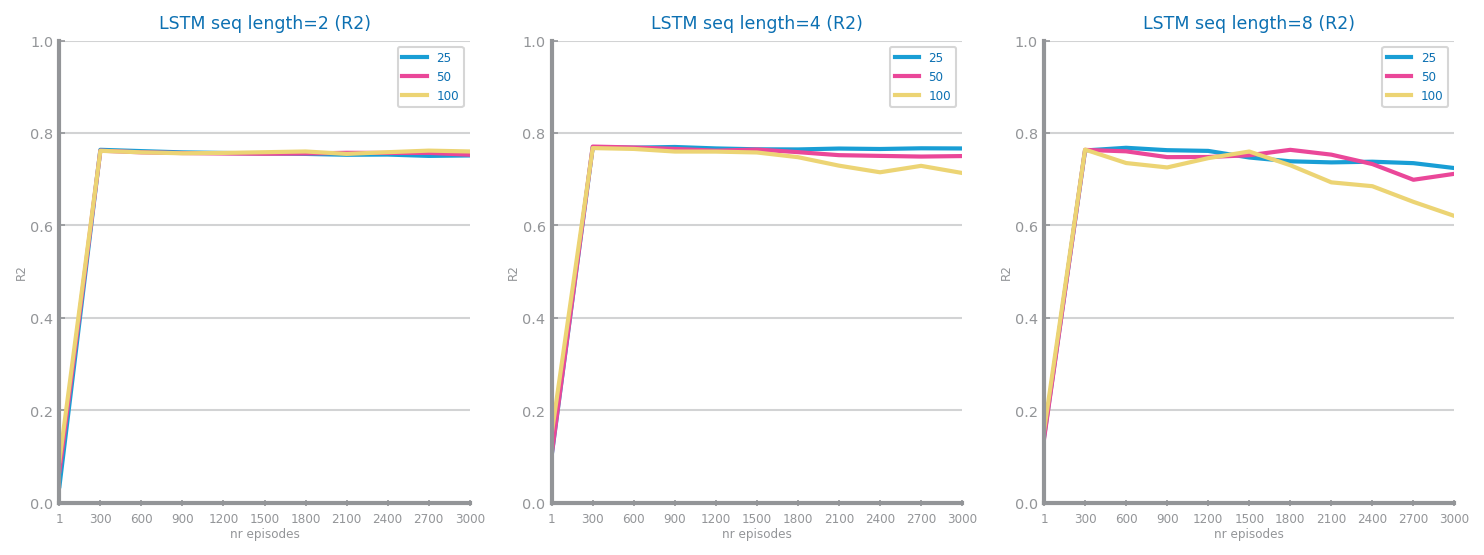

In [11]:
best_model, best_params = lstm_study(train, test, nr_episodes=3000, measure=measure)

{'RMSE': [0.46058864646738085, 0.45175397568659537], 'MAE': [0.34360936, 0.34956658]} {'MAPE': [1.7824494, 1.5147282], 'R2': [0.7909688533146393, 0.7704950599543191]}


<Axes: xlabel='TimeStamp', ylabel='Total'>

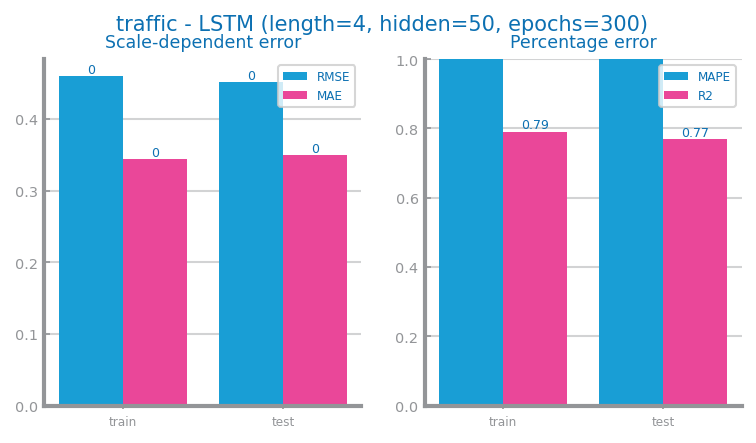

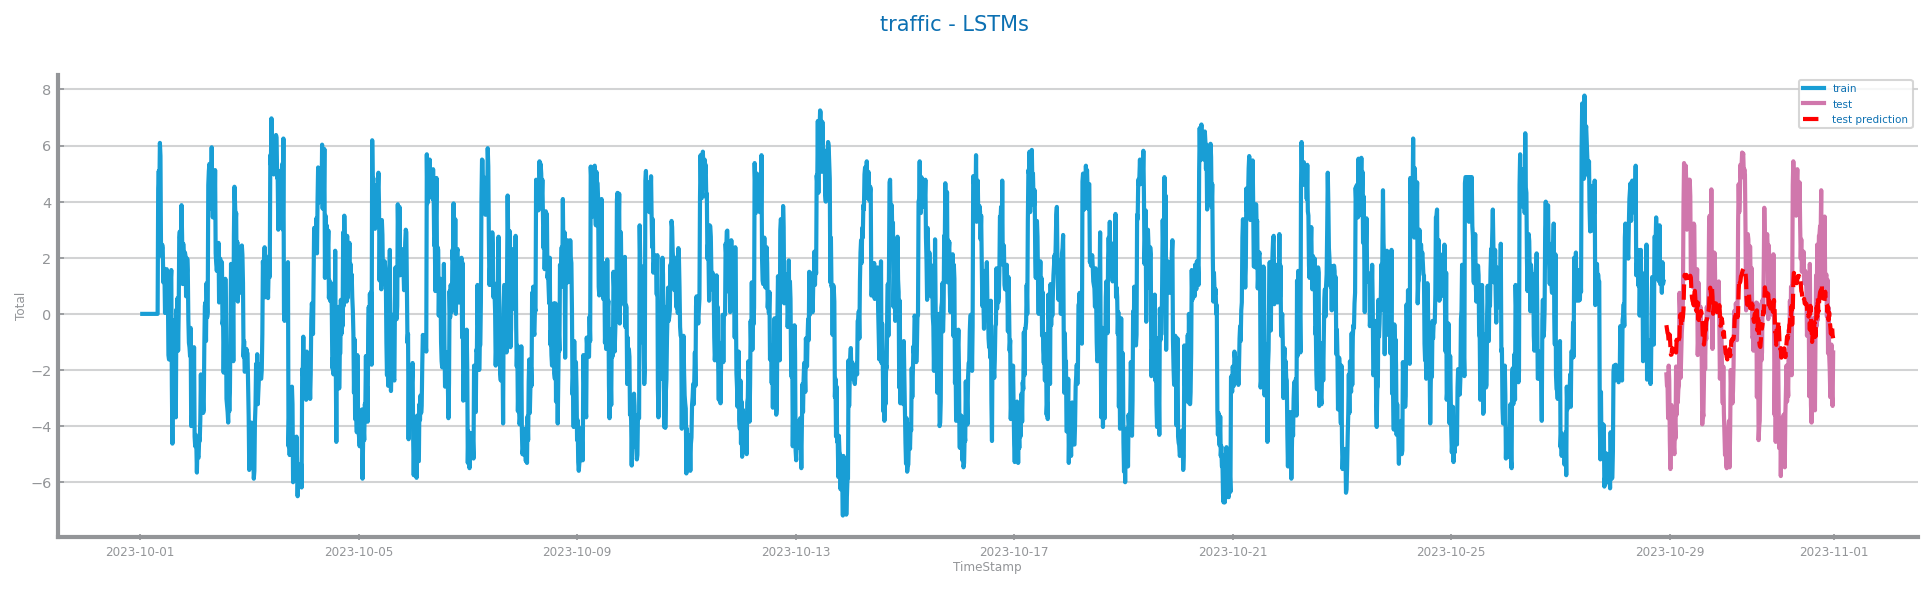

In [17]:
params = best_params["params"]
best_length = params[0]
trnX, trnY = prepare_dataset_for_lstm(train, seq_length=best_length)
tstX, tstY = prepare_dataset_for_lstm(test, seq_length=best_length)

prd_trn = best_model.predict(trnX)
prd_tst = best_model.predict(tstX)

dslabs.plot_forecasting_eval(
    train[best_length:],
    test[best_length:],
    prd_trn,
    prd_tst,
    title=f"{file_tag} - LSTM (length={best_length}, hidden={params[1]}, epochs={params[2]})",
)

series2 = data[[target]]
train, test = series2[:train_size], series2[train_size:]
pred_series: pd.Series = pd.Series(prd_tst.numpy().ravel(), index=test.index[best_length:])

dslabs.plot_forecasting_series(
    train[best_length:],
    test[best_length:],
    pred_series,
    title=f"{file_tag} - LSTMs ",
    xlabel="TimeStamp",
    ylabel=target,
)